<a href="https://colab.research.google.com/github/eunShim/BigDataCapstone/blob/main/bigdatacapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total CSV files: 297915
Sample data shape: (154152, 8)

[User u354378 action_type ratio]
action_type
enter          0.30
respond        0.30
submit         0.30
play_audio     0.05
pause_audio    0.05
Name: proportion, dtype: float64


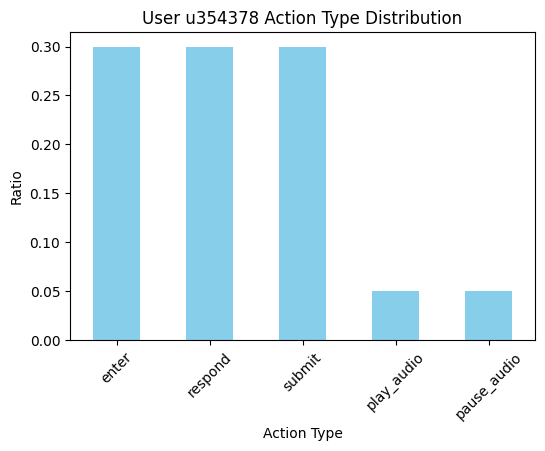

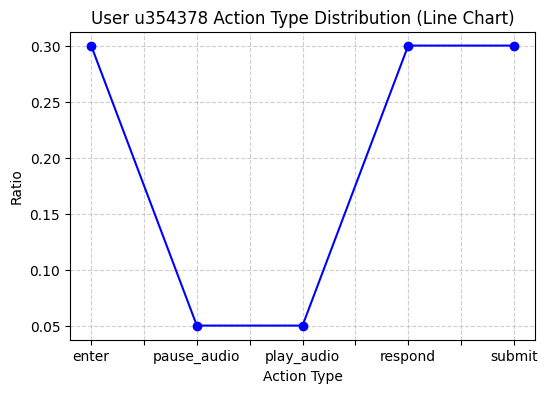


[Group-level average action_type ratio]
action_type
enter                0.280425
respond              0.273458
submit               0.232191
quit                 0.119847
pause_audio          0.090136
play_audio           0.088669
erase_choice         0.070954
undo_erase_choice    0.043462
pause_video          0.023383
play_video           0.023366
pay                  0.006275
Name: ratio, dtype: float64


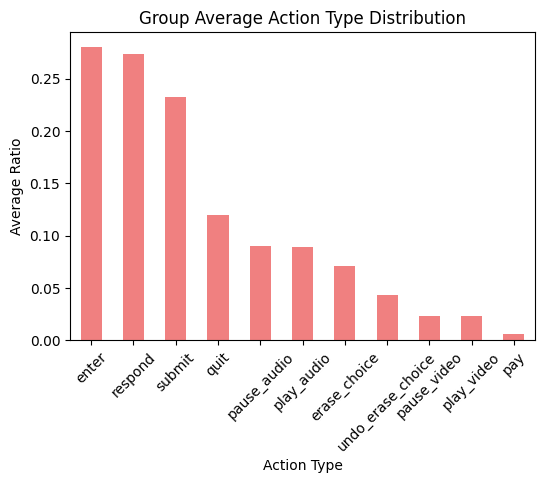

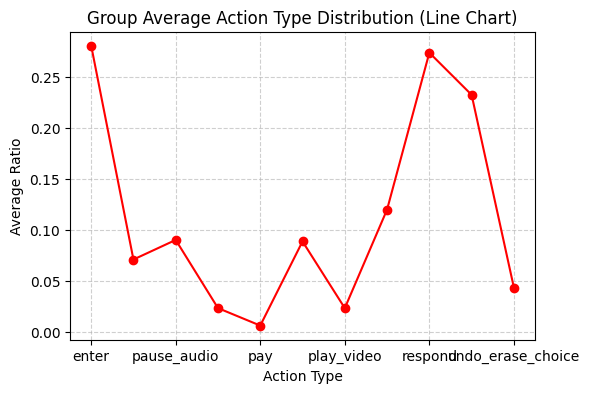

In [28]:
import zipfile
import random
import pandas as pd
import matplotlib.pyplot as plt

# =======================================
# 1. Load KT4 sample data (500 users)
# =======================================
zip_path = "/content/EdNet-KT4.zip"
zf = zipfile.ZipFile(zip_path)

file_list = [f for f in zf.namelist() if f.endswith(".csv") and not f.endswith("/")]
print("Total CSV files:", len(file_list))

sample_files = random.sample(file_list, 500)

dfs = []
for f in sample_files:
    try:
        with zf.open(f) as fp:
            df = pd.read_csv(fp)
            df["user_id"] = f.split("/")[-1].replace(".csv","")
            dfs.append(df)
    except Exception:
        continue

data = pd.concat(dfs, ignore_index=True)
print("Sample data shape:", data.shape)

# =======================================
# 2. Individual user action_type profile
# =======================================
rand_user = random.choice(data["user_id"].unique())
user_actions = data[data["user_id"]==rand_user]["action_type"].value_counts(normalize=True)

print(f"\n[User {rand_user} action_type ratio]")
print(user_actions)

# Bar chart (individual)
plt.figure(figsize=(6,4))
user_actions.plot(kind="bar", color="skyblue")
plt.title(f"User {rand_user} Action Type Distribution")
plt.ylabel("Ratio")
plt.xlabel("Action Type")
plt.xticks(rotation=45)
plt.show()

# Line chart (individual)
plt.figure(figsize=(6,4))
user_actions.sort_index().plot(kind="line", marker="o", color="blue")
plt.title(f"User {rand_user} Action Type Distribution (Line Chart)")
plt.ylabel("Ratio")
plt.xlabel("Action Type")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# =======================================
# 3. Group-level action_type profile
# =======================================
# Compute ratio per user
user_action_dist = (
    data.groupby(["user_id","action_type"]).size() /
    data.groupby("user_id").size()
).reset_index(name="ratio")

# Compute mean ratio across all users
group_actions = user_action_dist.groupby("action_type")["ratio"].mean().sort_values(ascending=False)

print("\n[Group-level average action_type ratio]")
print(group_actions)

# Bar chart (group-level)
plt.figure(figsize=(6,4))
group_actions.plot(kind="bar", color="lightcoral")
plt.title("Group Average Action Type Distribution")
plt.ylabel("Average Ratio")
plt.xlabel("Action Type")
plt.xticks(rotation=45)
plt.show()

# Line chart (group-level)
plt.figure(figsize=(6,4))
group_actions.sort_index().plot(kind="line", marker="o", color="red")
plt.title("Group Average Action Type Distribution (Line Chart)")
plt.ylabel("Average Ratio")
plt.xlabel("Action Type")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
